## Imports

In [1]:
import duckdb
import networkx as nx
import json
import pandas as pd
import matplotlib.pyplot as plt
import folium

from datetime import datetime
from geopy.distance import great_circle
from pyvis.network import Network
from shapely import wkt

## Constants

In [2]:
X_SHOP_LOCAL_BRANDS_PCT = 'RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT'
X_SHOP_ONLINE_BRANDS_PCT = 'RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT'
X_SHOP_PHYSICAL_BRANDS_PCT = 'RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT'
X_SHOP_SAME_CATEGORY_BRANDS_PCT = 'RELATED_CROSS_SHOPPING_SAME_CATEGORY_BRANDS_PCT'
X_SHOP_DIMENSIONS = ['local', 'online', 'physical', 'same_category']
LOCATION_NAME = 'LOCATION_NAME'
TOP_CATEGORY = 'TOP_CATEGORY'
RAW_NUM_CUSTOMERS = 'RAW_NUM_CUSTOMERS'
SPEND_PLACES_PATH = 'data/san-diego-county-places-spend.parquet' # added based on joined output

## Load Data

In [3]:
r1 = duckdb.read_parquet(SPEND_PLACES_PATH)
df = r1.to_df()
df.head()

,CITY,LATITUDE,LONGITUDE,PARENT_PLACEKEY,PLACEKEY,POLYGON_WKT,POSTAL_CODE,REGION,SAFEGRAPH_BRAND_IDS,STREET_ADDRESS,...,SPEND_BY_TRANSACTION_INTERMEDIARY,SPEND_DATE_RANGE_END,SPEND_DATE_RANGE_START,SPEND_PCT_CHANGE_VS_PREV_MONTH,SPEND_PCT_CHANGE_VS_PREV_YEAR,SPEND_PER_TRANSACTION_BY_DAY,SPEND_PER_TRANSACTION_PERCENTILES,SUB_CATEGORY,TOP_CATEGORY,TRANSACTION_INTERMEDIARY
0,San Diego,32.755488,-117.107622,None,22j-222@5z5-qdx-6zf,POLYGON ((-117.10754558444023 32.7555074919251...,92105.0,CA,SG_BRAND_1f2a4b730dc533366115ba7f5168b074,4090 El Cajon Blvd Ste C,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,-45.0,NaN,"[null,null,null,null,null,null,34.77,null,null...","{""25"":16.91,""75"":47.13}",Limited-Service Restaurants,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""No intermediary"",""value""..."
1,San Diego,32.762727,-117.131964,None,22m-222@5z5-qdy-d9z,POLYGON ((-117.13201920422857 32.7627738709169...,92116.0,CA,None,2873 Adams Ave,...,"{""key_value"":[{""key"":""Square"",""value"":203.92}]}",2025-08-01,2025-07-01,9.0,318.0,"[null,11.5,null,15.24,null,null,27.6,null,null...","{""25"":10.49,""75"":40.66}",Snack and Nonalcoholic Beverage Bars,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""Square"",""value"":10}]}"
2,San Diego,32.889963,-117.179930,None,22r-222@5z5-px8-v75,POLYGON ((-117.18009507918524 32.8901942559195...,92121.0,CA,None,6364 Ferris Sq,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,-55.0,-19.0,"[null,null,null,26.38,null,5,null,null,null,24...","{""25"":13.61,""75"":47.7}",None,"Advertising, Public Relations, and Related Ser...","{""key_value"":[{""key"":""No intermediary"",""value""..."
3,La Jolla,32.853546,-117.254233,zzy-222@5z5-pmy-r49,22t-222@5z5-pmy-mzf,POLYGON ((-117.25400457128175 32.8536535551412...,92037.0,CA,None,2261 Avenida de la Playa,...,"{""key_value"":[{""key"":""Shopify"",""value"":421.4}]}",2025-08-01,2025-07-01,235.0,30.0,"[null,null,31.25,null,null,null,53.88,null,53....","{""25"":35.53,""75"":70.99}",Sporting Goods Stores,"Sporting Goods, Hobby, and Musical Instrument ...","{""key_value"":[{""key"":""Shopify"",""value"":7}]}"
4,San Ysidro,32.545093,-117.038717,None,234-222@5z5-wp2-26k,POLYGON ((-117.0387910794577 32.54518979730449...,92173.0,CA,SG_BRAND_5179b21fc1d50950b99b4eecaa48c614,4449 Camino de la Plz,...,"{""key_value"":[{""key"":""No intermediary"",""value""...",2025-08-01,2025-07-01,23.0,0.0,"[9.04,3.88,9.21,12.28,19.16,21.02,11.08,28.73,...","{""25"":5.39,""75"":18.11}",Limited-Service Restaurants,Restaurants and Other Eating Places,"{""key_value"":[{""key"":""No intermediary"",""value""..."


In [4]:
def parse_json_to_tuple(json_str: str) -> list[tuple[str, int]]:
    if not json_str:
        return None
    try:
        data_dict = json.loads(json_str)

        # Handle the nested structure
        if isinstance(data_dict, dict) and "key_value" in data_dict:
            return [(item["key"], item["value"]) for item in data_dict["key_value"]]

        # If it's already a flat dict
        elif isinstance(data_dict, dict):
            return [(k, v) for k, v in data_dict.items()]

        # If it's a list of dicts already
        elif isinstance(data_dict, list):
            return [(item["key"], item["value"]) for item in data_dict]

        return None
    except (ValueError, SyntaxError, KeyError, TypeError):
        return None

## Parse Related Cross Shopping Columns

In [5]:
df['parsed_local_brands'] = df[X_SHOP_LOCAL_BRANDS_PCT].apply(parse_json_to_tuple)
df['parsed_online_brands'] = df[X_SHOP_ONLINE_BRANDS_PCT].apply(parse_json_to_tuple)
df['parsed_physical_brands'] = df[X_SHOP_PHYSICAL_BRANDS_PCT].apply(parse_json_to_tuple)
df['parsed_same_category_brands'] = df[X_SHOP_SAME_CATEGORY_BRANDS_PCT].apply(parse_json_to_tuple)

## Construct the graph

In [6]:
graphs = {
    "local": nx.DiGraph(),
    "online": nx.DiGraph(),
    "physical": nx.DiGraph(),
    "same_category": nx.DiGraph(),
}

df["brand_sets"] = df.apply(lambda row: {
    "local":        row["parsed_local_brands"],
    "online":       row["parsed_online_brands"],
    "physical":     row["parsed_physical_brands"],
    "same_category":row["parsed_same_category_brands"],
}, axis=1)

def add_nodes_and_edges(row):
    # shared node attributes
    location = row[LOCATION_NAME]
    category = row[TOP_CATEGORY]
    raw_num_customers = row[RAW_NUM_CUSTOMERS]
    latitude = row["LATITUDE"]
    longitude = row["LONGITUDE"]

    # For each graph, add this node
    for g in graphs.values():
        g.add_node(
            location,
            label=location,
            category=category,
            num_customers=raw_num_customers,
            latitude=latitude,
            longitude=longitude,
        )

    # For each (graph_name, brand_list) pair in this row
    for graph_name, brand_list in row["brand_sets"].items():
        if not brand_list:
            continue

        for brand, pct in brand_list:
            weight = pct / 100
            if weight > 0.01:
                graphs[graph_name].add_edge(location, brand, weight=weight)

df.apply(add_nodes_and_edges, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
8532    None
8533    None
8534    None
8535    None
8536    None
Length: 8537, dtype: object

In [7]:
# check graph nodes and edge counts
print('Local: ', graphs['local'].number_of_nodes(), graphs['local'].number_of_edges())
print('Online: ', graphs['online'].number_of_nodes(), graphs['online'].number_of_edges())
print('Physical: ', graphs['physical'].number_of_nodes(), graphs['physical'].number_of_edges())
print('Same Category: ', graphs['same_category'].number_of_nodes(), graphs['same_category'].number_of_edges())

Local:  4527 45689
Online:  4834 91328
Physical:  5674 103858
Same Category:  5342 22337


## Export Graph to GEXF

In [8]:
# export the graph to a GEXF file for visualization in Gephi
def export_graph(G: nx.DiGraph, name: str):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"graphs/{name}_graph_{timestamp}.gexf"
    nx.write_gexf(G, output_file)

for name, G in graphs.items():
    export_graph(G, name)

## Clustering

In [9]:
def compute_pagerank(G: nx.DiGraph):
    pagerank = nx.pagerank(G, alpha=0.85, weight='weight')
    return sorted(pagerank.items(), key=lambda item: item[1], reverse=True)

def compute_clustering(G: nx.DiGraph):
    clusters = nx.clustering(G)
    return sorted(clusters.items(), key=lambda item: item[1], reverse=True)

pagerank = compute_pagerank(graphs['local'])
clusters = compute_clustering(graphs['local'])

## Isolated Nodes

In [10]:
# find isolated nodes
def find_isolated_nodes(G: nx.DiGraph):
    isolated_nodes = list(nx.isolates(G))
    print(f"Number of isolated nodes: {len(isolated_nodes)}")
    print("Isolated nodes:", isolated_nodes)
    return isolated_nodes

isolated_local = find_isolated_nodes(graphs['local'])
isloated_online = find_isolated_nodes(graphs['online'])
isolated_physical = find_isolated_nodes(graphs['physical'])
isolated_same_category = find_isolated_nodes(graphs['same_category'])

Number of isolated nodes: 842
Isolated nodes: ['Dia Del Cafe', 'Roya', 'Everyday California', 'Pro Flowers', 'Active & Fit Direct', 'Sala Thai Massage', 'Nobelrags', 'Rx Smart Gear', 'Harmony Nail Lounge', 'Precision Diagnostics', 'Audi Escondido', 'Wind N Sea Towing', 'Pala Casino RV Resort', 'Red House Pizza', 'Sunset Pharmaceuticals Inc.', "Roberto's Mexican Food - Del Mar", 'Porto Vista Hotel', 'Sciarrino Marble', "Carnitas' Snack Shack - Petco Park", 'Dalton Toyota National City', 'Cake', 'OB Brewery', 'Nativo', 'Islandtat Evolve', 'Civic Helicopters', 'CashCo Pawn', "Aaron's", 'Pacific Mini Storage', 'Native Poppy', 'Aibertos Taco Shop', 'Mountain Spirits Liquor', 'Prince Hookah Cafe', 'Invictus Fitness', 'Lesslie Armstrong', 'Pine Valley Store', 'Honda of Escondido', "Rolberto's Taco Shop", 'LA Fitness', 'Nourish Medical Center', "L'Auberge Del Mar", 'Los Cabos Mexican Restaurant', 'Instant Checkmate', 'Cali Banh Mi', 'Steele Canyon Park', 'Kay Jewelers Fashion Valley Mall', 'Be

## Degree Analysis

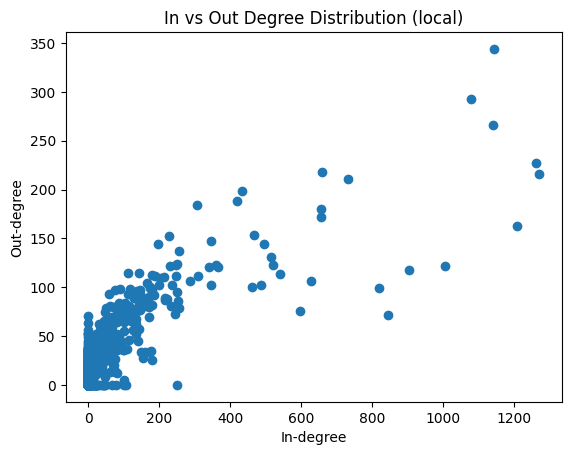

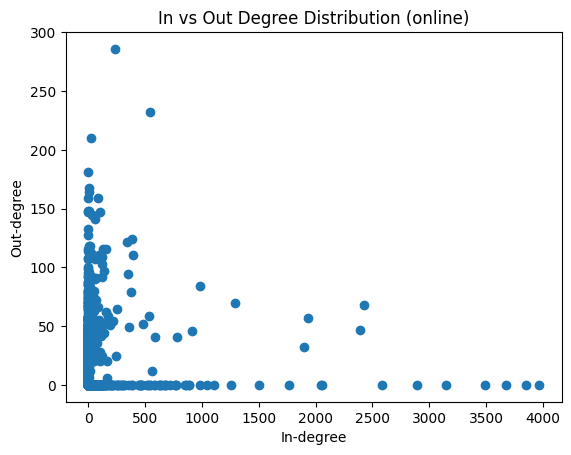

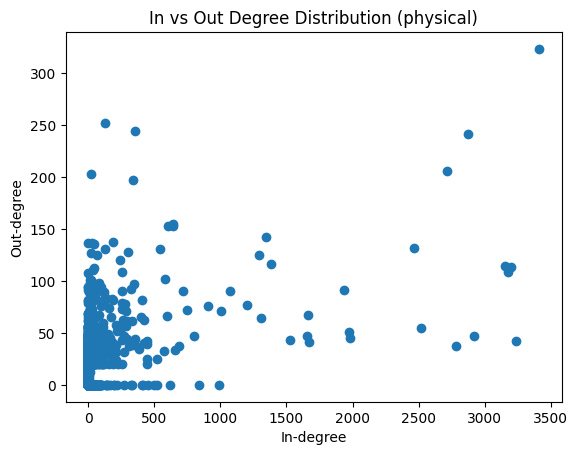

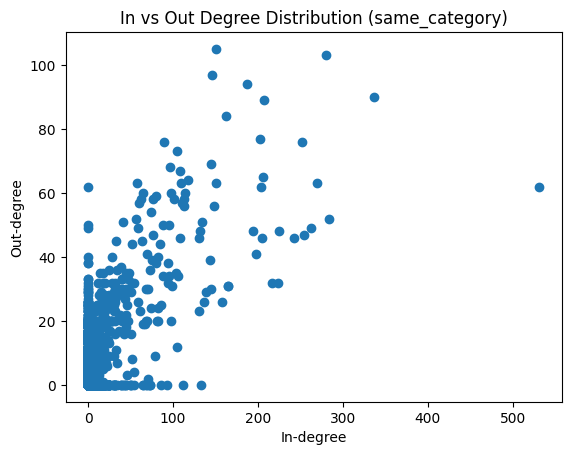

In [11]:
# find most influential nodes using out_degree 
def plot_in_out_degree(G: nx.DiGraph, related_x_shop_type: str):
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    plt.scatter(in_degrees.values(), out_degrees.values())
    plt.xlabel("In-degree")
    plt.ylabel("Out-degree")
    plt.title("In vs Out Degree Distribution ({})".format(related_x_shop_type))
    plt.show()

plot_in_out_degree(graphs['local'], 'local')
plot_in_out_degree(graphs['online'], 'online')
plot_in_out_degree(graphs['physical'], 'physical')
plot_in_out_degree(graphs['same_category'], 'same_category')

In [12]:
# find the top n nodes with the highest out_degree
def top_out_degree_nodes(num_nodes: int, G: nx.DiGraph) -> list[tuple[str, int]]:
    out_degrees = dict(G.out_degree())
    return sorted(out_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes]

top10_out_local = top_out_degree_nodes(10, graphs['local'])
top10_out_online = top_out_degree_nodes(10, graphs['online'])
top10_out_physical = top_out_degree_nodes(10, graphs['physical'])
top10_out_same_category = top_out_degree_nodes(10, graphs['same_category'])

for dimension in X_SHOP_DIMENSIONS:
    print(f"Top 10 out-degree nodes for {dimension} graph:")
    top10_out = top_out_degree_nodes(10, graphs[dimension])
    for node, degree in top10_out:
        print(f"{node}: {degree}")

Top 10 out-degree nodes for local graph:
Starbucks: 344
7-Eleven: 293
Chevron: 266
CVS: 227
Panda Express: 218
McDonald's: 216
Jack in the Box: 211
Jersey Mike's: 199
Domino's Pizza: 188
Subway: 184
Top 10 out-degree nodes for online graph:
7-Eleven: 286
Starbucks: 232
Subway: 210
The UPS Store: 181
AutoZone: 168
O'Reilly Auto Parts: 164
Domino's Pizza: 159
Jersey Mike's: 159
Dollar Tree: 148
Shell Oil: 148
Top 10 out-degree nodes for physical graph:
7-Eleven: 323
The UPS Store: 252
Subway: 244
Starbucks: 241
Shell Oil: 206
PostalAnnex+: 203
United States Postal Service (USPS): 197
AutoZone: 155
Carl's Jr.: 153
Domino's Pizza: 153
Top 10 out-degree nodes for same_category graph:
Subway: 105
Denny's: 103
Jersey Mike's: 97
Jack in the Box: 94
Starbucks: 90
Panda Express: 89
Domino's Pizza: 84
IHOP: 77
McDonald's: 76
Smart & Final: 76


In [13]:
# find the top n nodes with the highest in_degree
def top_in_degree_nodes(num_nodes: int, G: nx.DiGraph) -> list[tuple[str, int]]:
    in_degrees = dict(G.in_degree())
    return sorted(in_degrees.items(), key=lambda item: item[1], reverse=True)[:num_nodes]

for dimension in X_SHOP_DIMENSIONS:
    print(f"Top 10 in-degree nodes for {dimension} graph:")
    top10_in = top_in_degree_nodes(10, graphs[dimension])
    for node, degree in top10_in:
        print(f"{node}: {degree}")

Top 10 in-degree nodes for local graph:
McDonald's: 1272
CVS: 1263
Vons: 1211
Starbucks: 1145
Chevron: 1143
7-Eleven: 1081
Target: 1006
Ralphs: 905
Walmart: 847
Trader Joe's: 820
Top 10 in-degree nodes for online graph:
Apple: 3967
Amazon: 3849
Amazon Marketplace: 3680
Netflix: 3491
Uber: 3147
Spotify: 2897
Amazon Prime Video: 2583
AT&T: 2424
Target: 2393
Hulu: 2060
Top 10 in-degree nodes for physical graph:
7-Eleven: 3411
Costco: 3236
CVS: 3195
McDonald's: 3179
Chevron: 3153
Target: 2916
Starbucks: 2873
Walmart: 2783
Shell Oil: 2718
Chick-fil-A: 2515
Top 10 in-degree nodes for same_category graph:
Raising Cane's: 531
Starbucks: 336
Chili's Grill & Bar: 284
Denny's: 280
CAVA: 269
Buffalo Wild Wings: 262
BJ's Restaurants: 254
McDonald's: 252
Olive Garden: 242
Chick-fil-A: 225


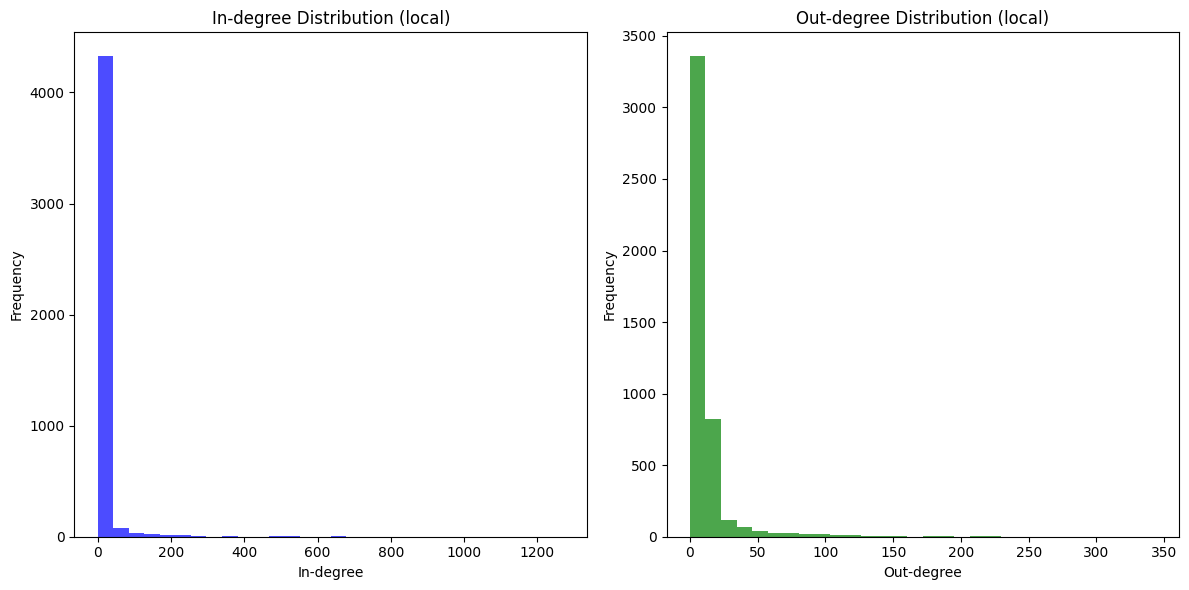

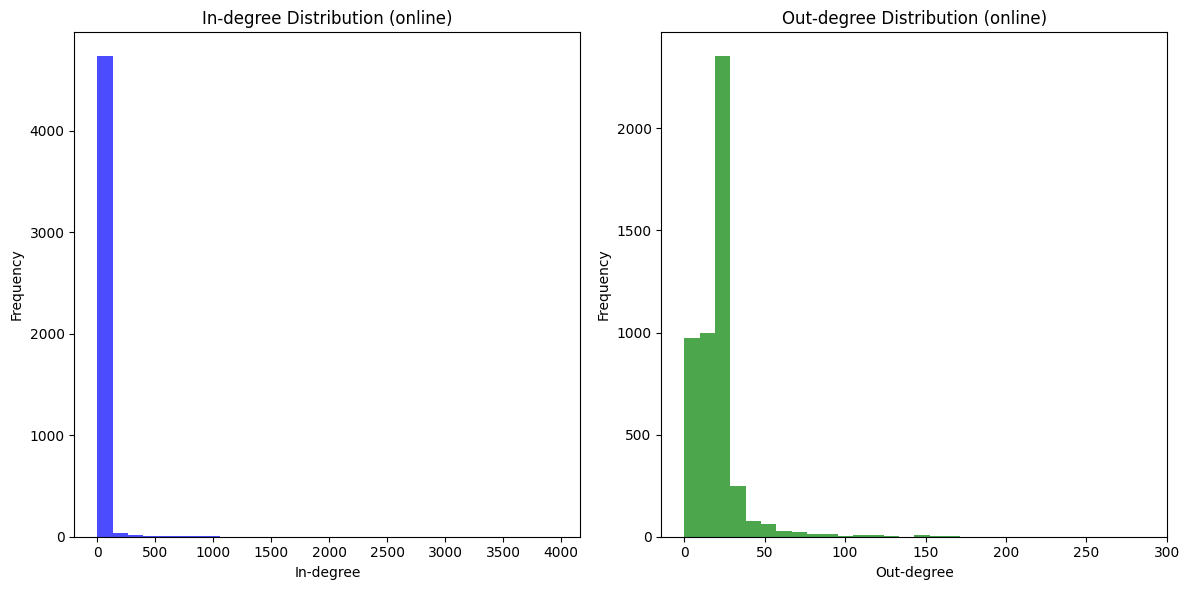

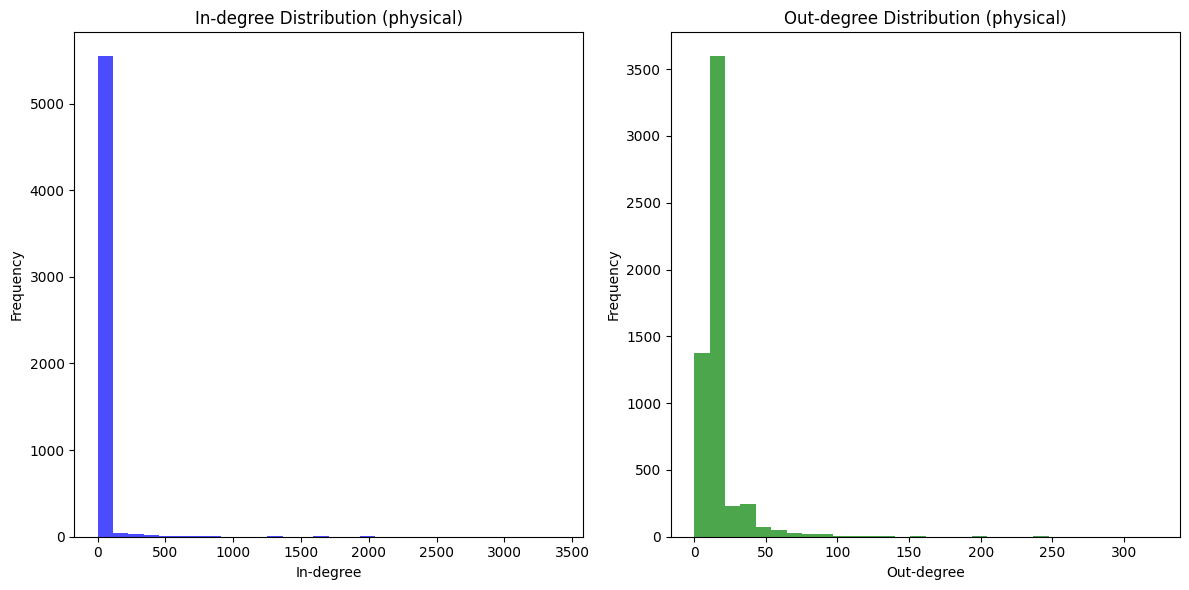

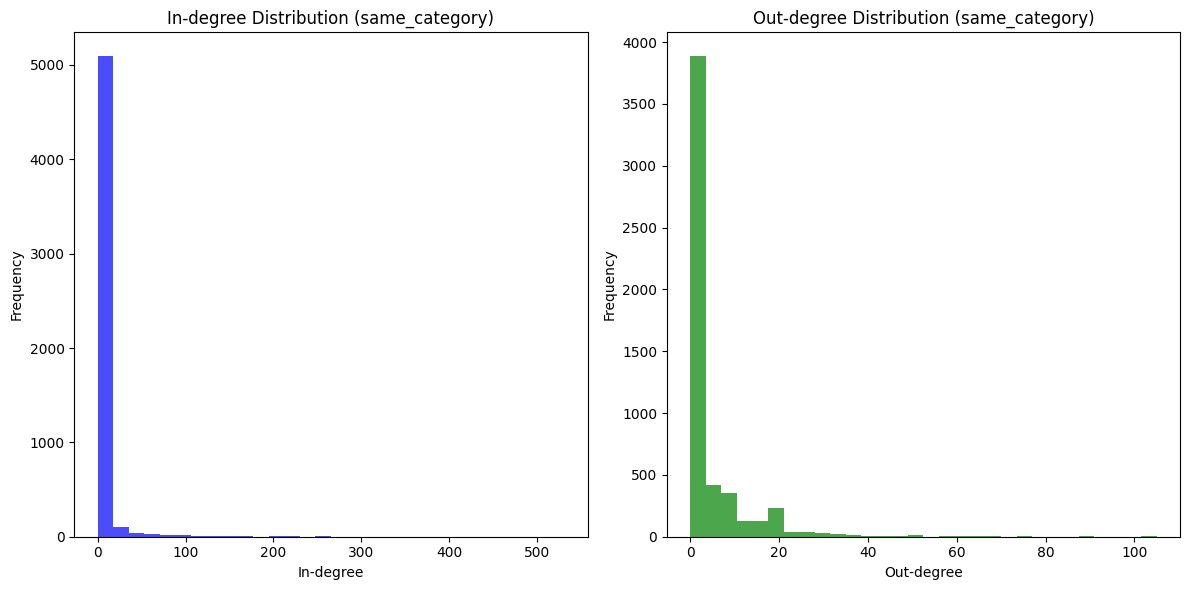

In [16]:
# plot distribution of in-degrees and out-degrees
def plot_degree_distribution(G: nx.DiGraph, related_x_shop_type: str):
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=30, color='blue', alpha=0.7)
    plt.xlabel("In-degree")
    plt.ylabel("Frequency")
    plt.title("In-degree Distribution ({})".format(related_x_shop_type))

    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=30, color='green', alpha=0.7)
    plt.xlabel("Out-degree")
    plt.ylabel("Frequency")
    plt.title("Out-degree Distribution ({})".format(related_x_shop_type))

    plt.tight_layout()
    plt.show()

plot_degree_distribution(graphs['local'], 'local')
plot_degree_distribution(graphs['online'], 'online')
plot_degree_distribution(graphs['physical'], 'physical')
plot_degree_distribution(graphs['same_category'], 'same_category')

## 2nd Degree Neighbors

In [ ]:
def first_degree_neighbors(node: str, G: nx.DiGraph) -> set[str]:
    """
    Return the 1st-degree neighbors of `node` in a directed graph.
    """
    if node not in G:
        return set()
    return set(G.successors(node))

def second_degree_neighbors(node: str, G: nx.DiGraph) -> set[str]:
    """
    Return the 2nd-degree neighbors of `node` in a directed graph.
    Excludes the node itself and direct 1st-degree neighbors.
    """
    if node not in G:
        return set()
    first = set(G.successors(node))
    second = set()
    for n in first:
        second.update(G.successors(n))
    second -= first
    second.discard(node)
    return second

In [ ]:
second_degree_neighbors("ALDI", graphs['local'])

### Include distance as a filter

We will expand this analysis by applying a function that allows filtering based on distance for a given node or location. We use geopy for its accuracy but haversine distance can also be used.

In [ ]:
# Look at known locations in Encinitas for testing
df[['LATITUDE', 'LONGITUDE', 'LOCATION_NAME', 'POSTAL_CODE']].loc[df['POSTAL_CODE'] == 92024].head(20)

In [ ]:
place_1 = df.iloc[787]
place_2 = df.iloc[288]

print(place_1['LOCATION_NAME'])
print(place_2['LOCATION_NAME'])

In [ ]:
# Get the latitude and longitude for the two locations
place_1_lat_long = (place_1['LATITUDE'], place_1['LONGITUDE'])
place_2_lat_long = (place_2['LATITUDE'], place_2['LONGITUDE'])

# Print the distance between the two locations, this is correct
print(great_circle(place_1_lat_long, place_2_lat_long).miles)

In [ ]:
def get_nodes_within_radius(G, center_node, radius_mi):
    """
    Get all nodes within a given radius (in km) of a center node.
    Uses geodesic distance for accuracy.
    """
    if center_node not in G:
        return []
    
    center_lat = G.nodes[center_node].get('latitude')
    center_lon = G.nodes[center_node].get('longitude')
    
    if center_lat is None or center_lon is None:
        print(f"Warning: {center_node} does not have latitude/longitude data")
        return []
    
    center_point = (center_lat, center_lon)
    nodes_within_radius = []
    
    for node in G.nodes():
        node_lat = G.nodes[node].get('latitude')
        node_lon = G.nodes[node].get('longitude')
        
        if node_lat is None or node_lon is None:
            continue
        
        node_point = (node_lat, node_lon)
        distance = great_circle(center_point, node_point).miles
        
        if distance <= radius_mi:
            nodes_within_radius.append((node, distance))
    
    nodes_within_radius.sort(key=lambda x: x[1])
    return nodes_within_radius

In [ ]:
get_nodes_within_radius(G, "Target", 1)

### Now we will map to show available locations and test distance
This evaluation shows examples of polygons available in our dataset and how down stream analysis can be used by stakeholders to make more accurate decisons with accurate visualizations 

In [ ]:
df_enc = df.loc[df['POSTAL_CODE'] == 92024]

In [ ]:
# Convert POLYGON_WKT to geometry
df_enc['geometry'] = df_enc['POLYGON_WKT'].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)

# Create GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(df_enc, geometry='geometry', crs='EPSG:4326')

In [ ]:
# Create map, centered on Encinitas for my test
m = folium.Map(location=[33.036986, -117.292447], zoom_start=10)

In [ ]:
# Now I will add polygons to my encinitas map
folium.GeoJson(
    gdf[['LOCATION_NAME', 'TOP_CATEGORY', 'geometry']].head(1000).to_json(), 
    style_function=lambda feature: {
        'fillColor': 'lightblue',
        'color': 'blue',
        'weight': 1,
        'fillOpacity': 0.5,
    },
    tooltip=folium.GeoJsonTooltip(fields=['LOCATION_NAME'], aliases=['Location:']),
    popup=folium.GeoJsonPopup(fields=['LOCATION_NAME', 'TOP_CATEGORY'])
).add_to(m)

# Add a marker for the two locations I used before and draw a line for distance check
folium.Marker(
    location=place_1_lat_long,
    popup=place_1['LOCATION_NAME'],
    tooltip=place_1['LOCATION_NAME']
).add_to(m)

folium.Marker(
    location=place_2_lat_long,
    popup=place_2['LOCATION_NAME'],
    tooltip=place_2['LOCATION_NAME']
).add_to(m)

folium.PolyLine(
    locations=[place_1_lat_long, place_2_lat_long],
    weight=2,
    color='red'
).add_to(m)

m.save('polygon_map.html')
m